In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import re
from nltk.corpus import stopwords

# 1. Importação e Leitura dos Dados

In [2]:
# importação e leitura dos dados
df = pd.read_json('receitas.json')
df.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [3]:
# visualizar linhas X colunas
df.shape

(20130, 11)

# 2. Análise e Remoção de Registros Duplicados

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Para não comprometer a análise, é preciso eliminar os registros duplicados do data frame. Primeiro, é necessário analisar a existência dessas duplicações e para isso, é necessário converter as variáveis "directions", "categories" e "ingredients" em strings, pois os duplicated() e drop_duplicates() não trabalham com listas.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
#Converter list para str, para remover os registros duplicados
df["str_directions"] = df["directions"].astype(str)
df["str_categories"] = df["categories"].astype(str)
df["str_ingredients"] = df["ingredients"].astype(str)

subset = df.columns.to_list()

subset.remove('directions')
subset.remove('categories')
subset.remove('ingredients')

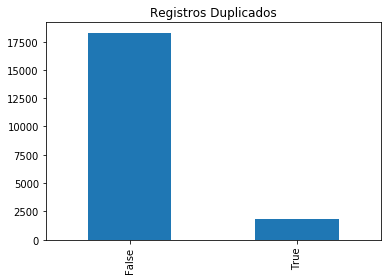

In [5]:
# Analisa a existência de registros duplicados
df.duplicated(subset).value_counts().plot.bar().set_title("Registros Duplicados");

In [6]:
#Eliminando os registros duplicados duplicadas
df = df.drop_duplicates(subset)
df.shape

(18296, 14)

# 3. Análise e Tratamento de Valores Nulos

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Agora, será necessário verificar se existem valores nulos no data frame. Dessa forma, será mostrado um gráfico de barras que mostra que quantidade de valores existentes em cada variável.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

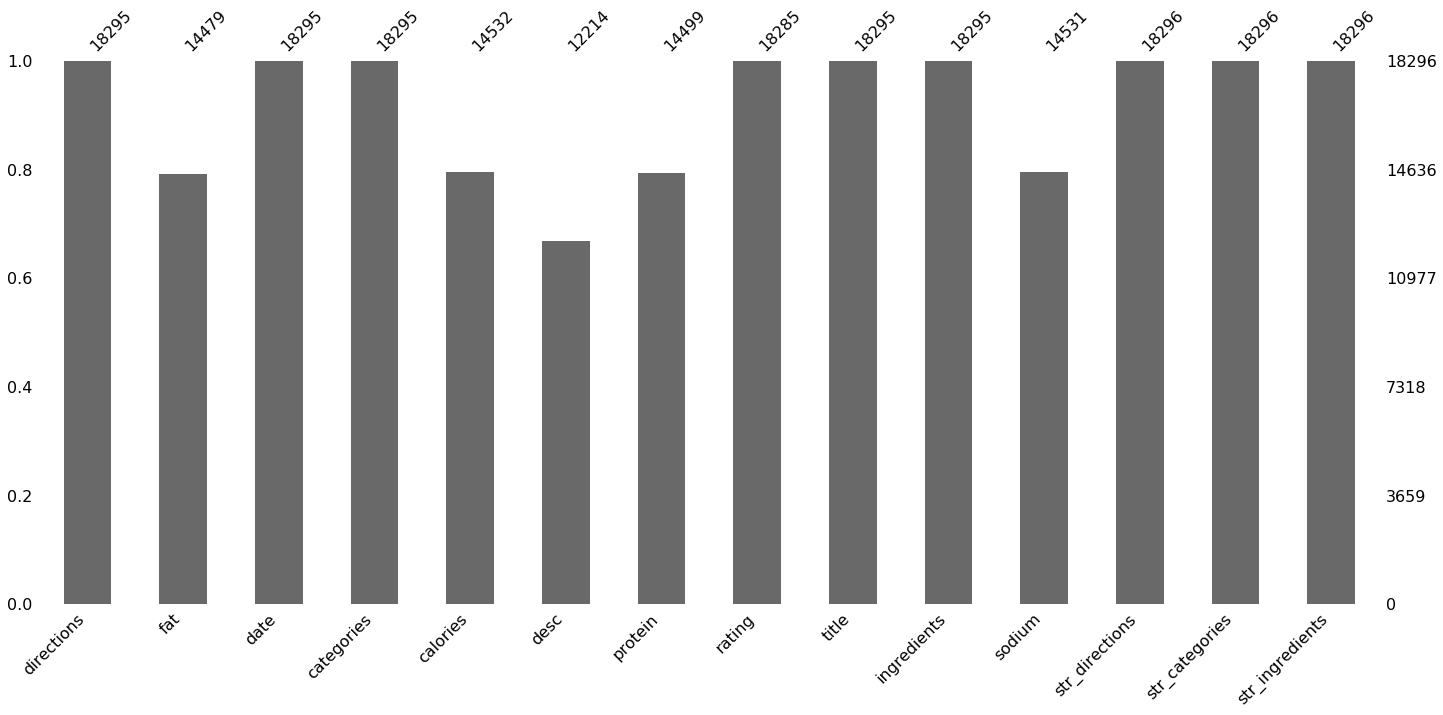

In [7]:
# Visualizar valores nulos
msno.bar(df);

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Como mostrado no gráfico acima, considerando que a quantidade atual de registros é de 18296, todas variáveis da base contém valores nulos. Abaixo, é possível visualizar a correlação dos valores nulos em cada variável.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

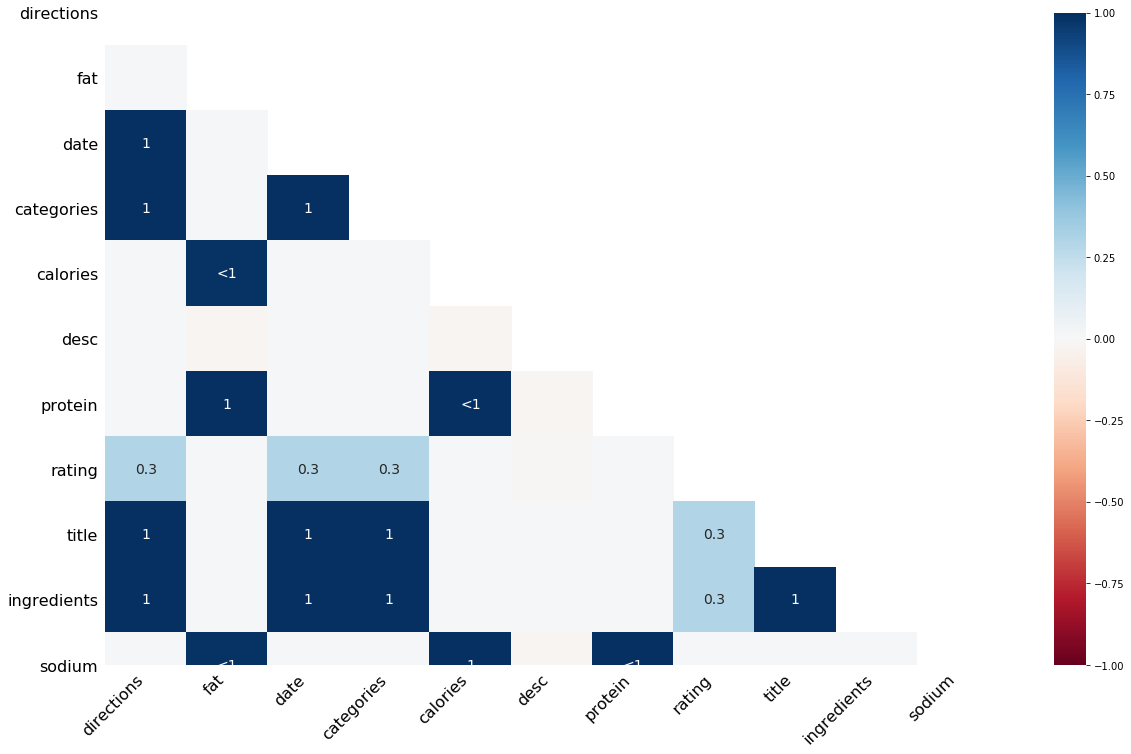

In [8]:
# Visualizar correlação entre de variáveis com valores nulos
msno.heatmap(df);

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Como mostrado no gráfico acima, percebe-se que, com exceção da variável "desc", os valores nulos de todas as variáveis têm correlação. Por exemplo, todos os registros que têm valores nulos no campo "protein" também têm valores nulos no campo "fat". Todas essas features são grande importância para seguir a análise, por isso será necessário filtrar os valores não nulos. Abaixo é possível analisar como ficaram as variáveis.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

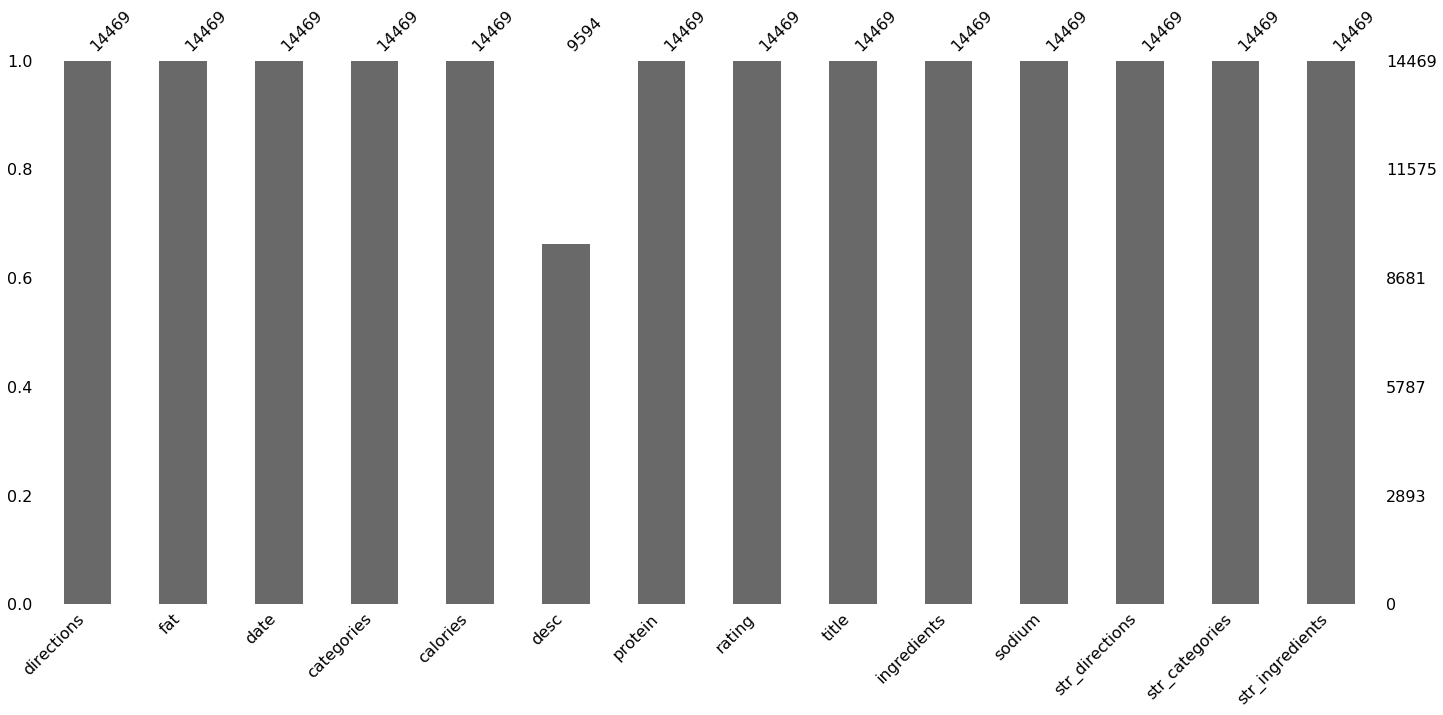

In [9]:
# Apagar valores vazios, exceto da coluna "desc" e vizualizar 
df = df.dropna(subset=['directions', 'fat', 'date', 'categories', 'calories', 'protein', 'rating', 'title', 'ingredients', 'sodium'])
msno.bar(df);

# 4. Análise e Remoção de Outliers

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Com o tratamento de alguns valores vazios, agora será necessário analisar a existência de possíveis outliers. Dessa forma, será mostrado gráficos boxplot das importantes features numéricas "fat", "calories", "protein" e "sodium". Para a visualização, também poderiam ser utilizados gráficos de dispersão, entretanto, os gráficos boxplot, comumentes utilizados, apresentam algumas outras informações de maneira mais clara, como a mediana e o Intervalo interquartil, além dos outliers.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

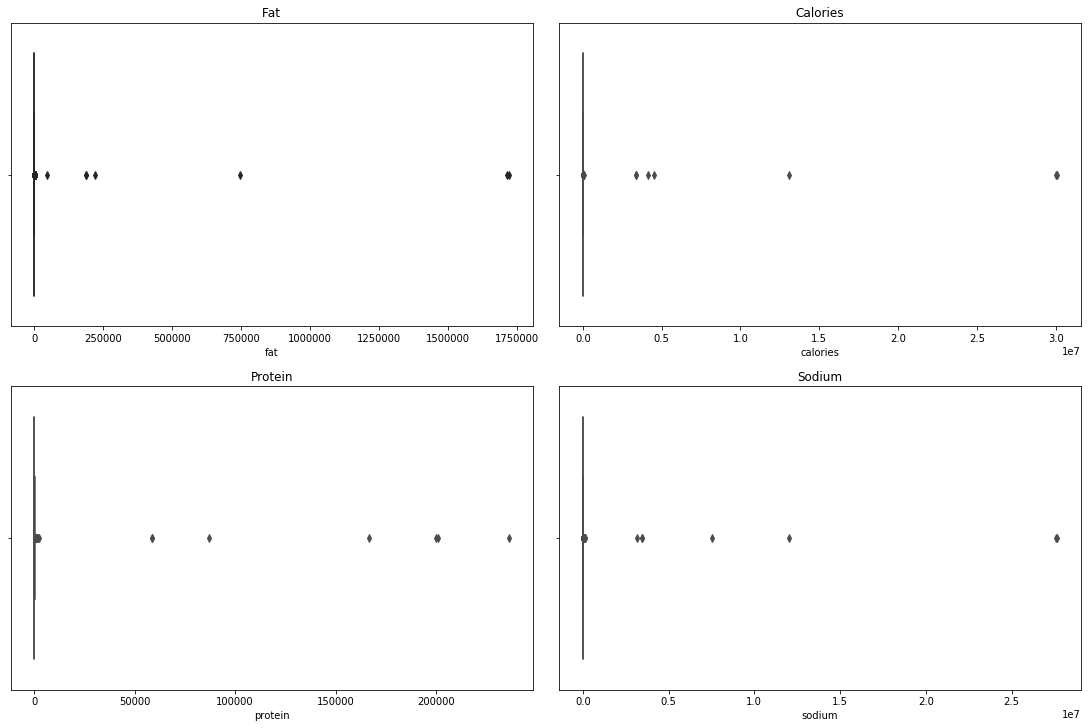

In [10]:
# analisar a existência de outliers
fig1, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), constrained_layout=True, sharey=True)
sns.boxplot(data=df, x='fat', ax=axes[0,0], color = 'green').set_title("Fat")
sns.boxplot(data=df, x='calories', ax=axes[0,1], color = 'blue').set_title("Calories")
sns.boxplot(data=df, x='protein', ax=axes[1,0], color = 'yellow').set_title("Protein")
sns.boxplot(data=df, x='sodium', ax=axes[1,1], color = 'red').set_title("Sodium");

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Como pode ser observado nos gráficos acima, todas as features "fat", "calories", "protein" e "sodium", apresentam valores muito discrepantes. Para identificar e removê-los, será utilizado a técnica de intervalo interquartil (IQR) e será definido limites inferior e superior para cada variável. É importante destacar, que para este processo, poderiam ser utilizados alguns algoritmos como DBScan ou Isolation Forest, mas a técnica de intervalo interquartil, além de mais comum e muito eficiente, não necessita de um aprendizado máquina.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
# removendo outliers da variavel calories
q1_cal = df['calories'].quantile(0.25)
q3_cal = df['calories'].quantile(0.75)
iqr_cal = q3_cal - q1_cal
inferior_cal = q1_cal - (1.5 * iqr_cal)
superior_cal = q3_cal + (1.5 * iqr_cal)

print('Limite inferior: ' + str(inferior_cal) + ' | Limite superior: ' + str(superior_cal))

Limite inferior: -386.5 | Limite superior: 1193.5


In [12]:
# como existem valores calóricos negativos, definiremos o valor de limite inferior = 0
df = df.query('calories > 0 & calories < 1193.5')

In [13]:
# removendo outliers da variavel fat
q1_fat = df['fat'].quantile(0.25)
q3_fat = df['fat'].quantile(0.75)
iqr_fat = q3_fat - q1_fat
inferior_fat = q1_fat - (1.5 * iqr_fat)
superior_fat = q3_fat + (1.5 * iqr_fat)

print('Limite inferior: ' + str(inferior_fat) + ' | Limite superior: ' + str(superior_fat))

Limite inferior: -25.0 | Limite superior: 63.0


In [14]:
# definiremos o valor do limite superior
df = df.query('fat < 63.0')

In [15]:
# removendo outliers da variavel fat
q1_protein = df['protein'].quantile(0.25)
q3_protein = df['protein'].quantile(0.75)
iqr_protein = q3_protein - q1_protein
inferior_protein = q1_protein - (1.5 * iqr_protein)
superior_protein = q3_protein + (1.5 * iqr_protein)

print('Limite inferior: ' + str(inferior_protein) + ' | Limite superior: ' + str(superior_protein))

Limite inferior: -24.0 | Limite superior: 48.0


In [16]:
# definiremos o valor do limite superior
df = df.query('protein < 48.0')

In [17]:
# removendo outliers da variavel sodium
q1_sodium = df['sodium'].quantile(0.25)
q3_sodium = df['sodium'].quantile(0.75)
iqr_sodium = q3_sodium - q1_sodium
inferior_sodium = q1_sodium - (1.5 * iqr_sodium)
superior_sodium = q3_sodium + (1.5 * iqr_sodium)

print('Limite inferior: ' + str(inferior_sodium) + ' | Limite superior: ' + str(superior_sodium))

Limite inferior: -700.5 | Limite superior: 1343.5


In [18]:
# definiremos o valor do limite superior
df = df.query('sodium < 1343.5')

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Nos gráficos abaixo, é possível verificar a melhora dos resultados após a remoção dos outliers.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

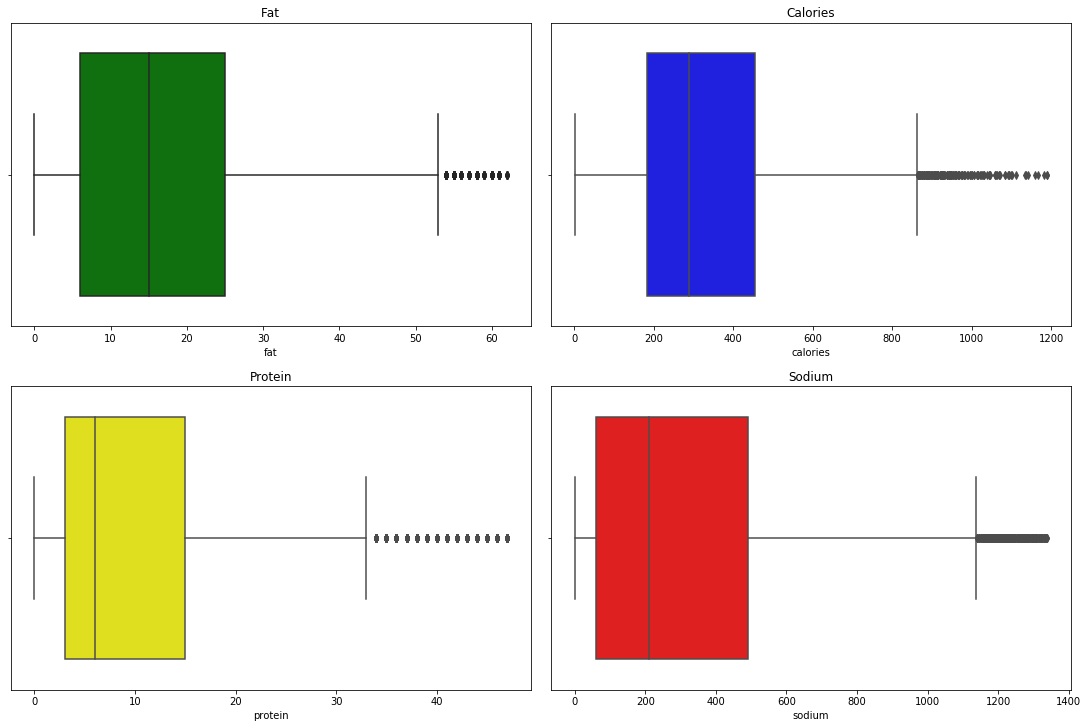

In [19]:
# analisar a existência de outliers
fig1, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), constrained_layout=True, sharey=True)
sns.boxplot(data=df, x='fat', ax=axes[0,0], color='green').set_title("Fat")
sns.boxplot(data=df, x='calories', ax=axes[0,1], color='blue').set_title("Calories")
sns.boxplot(data=df, x='protein', ax=axes[1,0], color='yellow').set_title("Protein")
sns.boxplot(data=df, x='sodium', ax=axes[1,1], color='red').set_title("Sodium");

# 5. Engenharia de Features

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Nesta fase, serão criadas algumas features a fim de facilitar a análise e obter mais conhecimentos.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
# Cria a coluna "count_directions" que informa a quantidade de passos de uma receita
df['count_directions'] = [len(directions) for directions in df['directions']]

# Cria a coluna "count_ingredients" que informa a quantidade de ingredientes de uma receita
df['count_ingredients'] = [len(ingredients) for ingredients in df['ingredients']]

# Criar a coluna "year"
df['year'] = df['date'].dt.year

# Criar a coluna "month"
df['month'] = df['date'].dt.month

# 6. Análise dos Dados

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Abaixo é possível visualizar a correlação linear entre as variáveis numéricas, através do gráfico heatmap. É possível identificar uma correlação forte entre as variáveis "fat" e "calories", "count_ingredients" e "year"; e uma correlação moderada entre as variáveis "protein" e "fat", "protein" e "calories", "protein" e "sodium", "count_ingredients" e "count_directions".
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

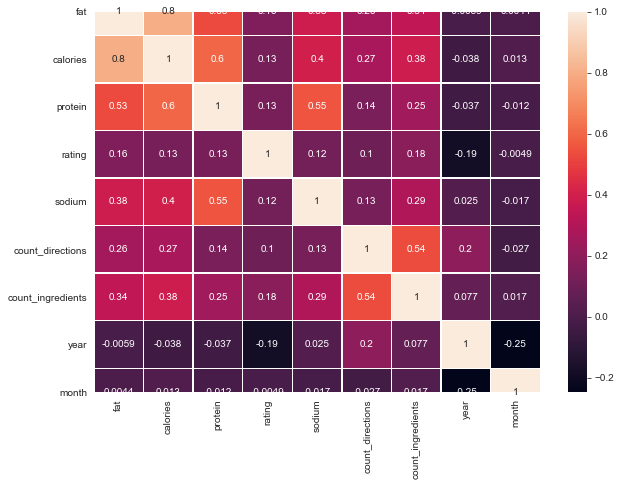

In [21]:
# Visualizar correlação das variáveis numéricas
plt.figure(figsize=(10,7))
sns.set_style('darkgrid')
sns.heatmap(df.corr(),annot=True,linewidths=.5);

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
A seguir tem-se o gráfico de histograma da variável "rating", onde é possível observar que a maior parte da classificação encontra-se entre 3,5 e 5.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

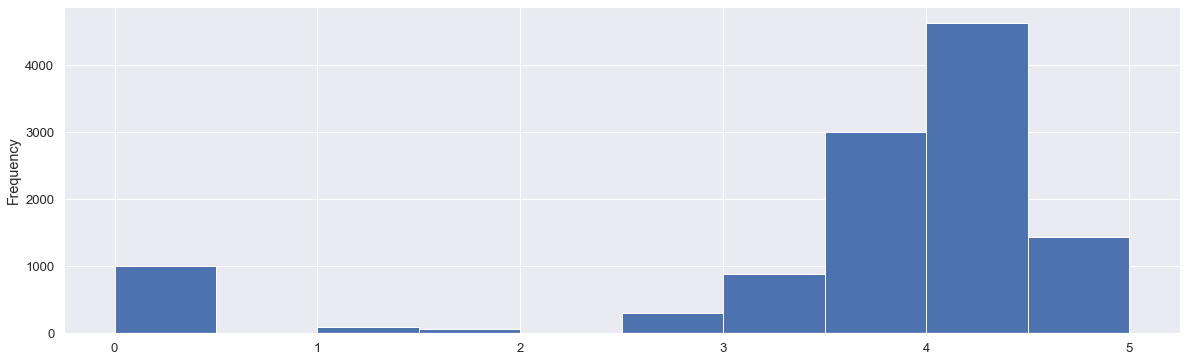

In [22]:
# Distribuiçã do rating
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
df['rating'].plot.hist();

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Abaixo é possível visualizar de distribuição com a frequência relativa da quantidade de instruções, onde perceptível que a maioria das receitas têm entre 1 e 5 instruções para serem realizadas.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


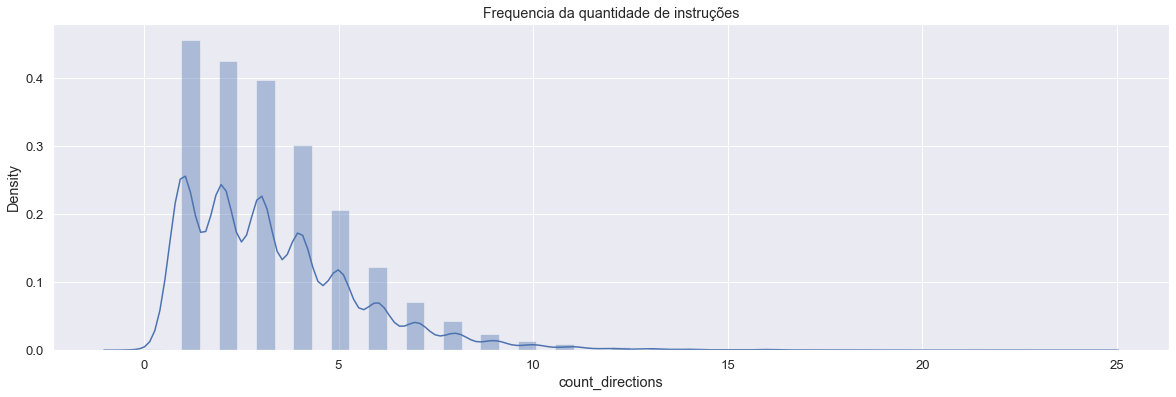

In [23]:
# Frequencia da quantidade de instruções
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
sns.distplot(df['count_directions'],kde = True ).set_title('Frequencia da quantidade de instruções');

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

No gráfico de linha a seguir tem-se a Quantidade de Instruções por Rating, onde percebe-se que as receitas de maiores notas, entre 4 e 5, têm as maiores quantidade de instruções. Pode-se afirmar que as receitas mais complexas, têm as melhores avaliações.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

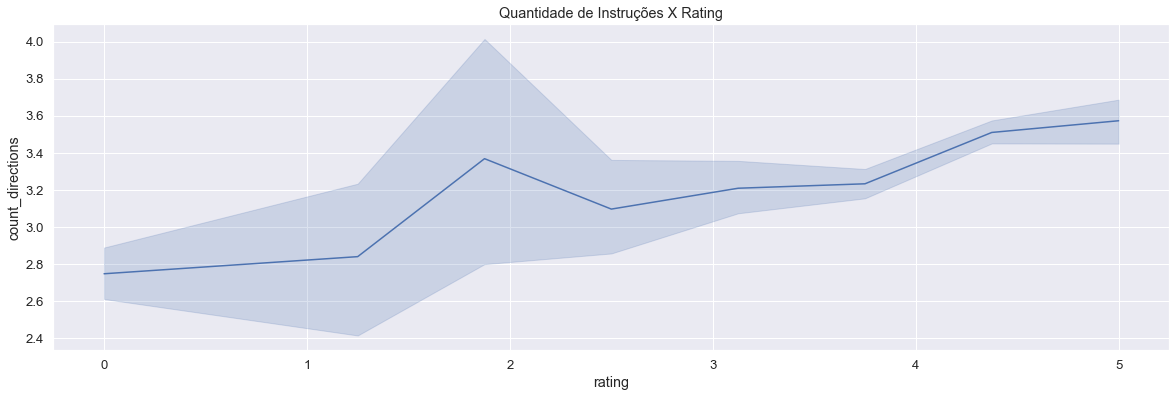

In [24]:
# Quantidade de Instruções X Rating
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
sns.lineplot(data=df,x='rating', y='count_directions').set_title('Quantidade de Instruções X Rating');

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Abaixo, os gráficos de linha mostram a features "fat", "calories", "protein" e "sodium" por "rating", onde percebe-se que as receitas de maiores notas, entre 4 e 5, têm as maiores quantidade de gordura, caloria, proteína e sódio. Pode-se afirmar que as receitas menos saudáveis, têm as melhores avaliações.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

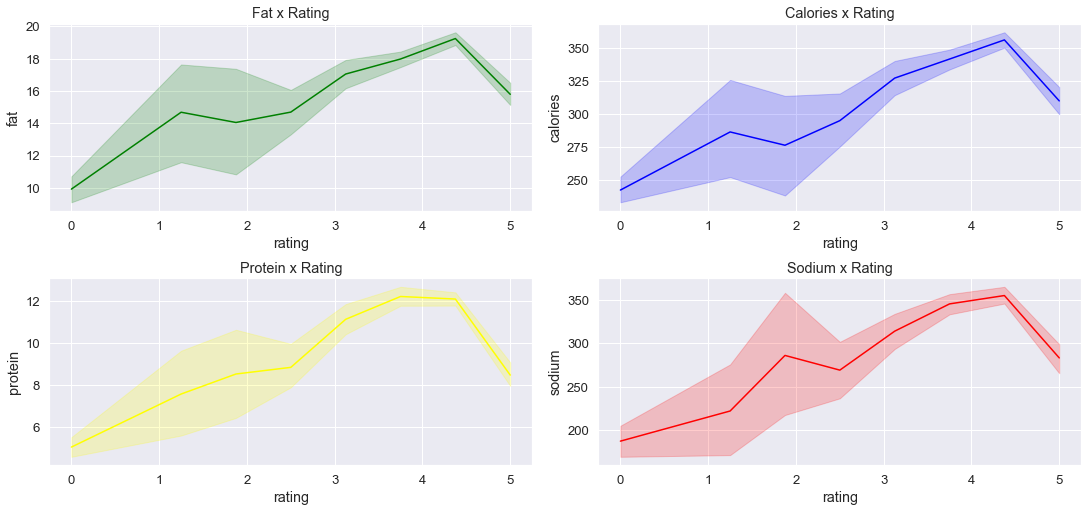

In [25]:
# Plot nutrients X ratin
fig1, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 7), constrained_layout=True)
sns.lineplot(x="rating", y="fat", data=df, ax=axes[0,0], color='green').set_title("Fat x Rating")
sns.lineplot(x="rating", y="calories", data=df, ax=axes[0,1], color='blue').set_title("Calories x Rating")
sns.lineplot(x="rating", y="protein", data=df, ax=axes[1,0], color='yellow').set_title("Protein x Rating")
sns.lineplot(x="rating", y="sodium", data=df, ax=axes[1,1], color='red').set_title("Sodium x Rating");

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
No gráfico de barras a seguir, é possível visualizar a 30 categorias que são mais frequentes na base de dados, observando-se da esquerda para a direita.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

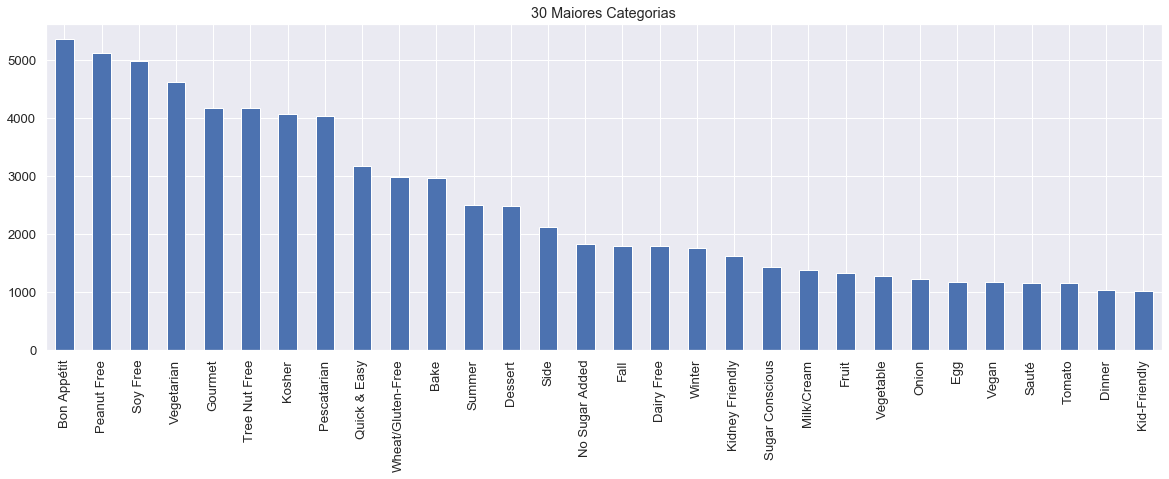

In [26]:
# Top 30 categorias que aparecem mais vezes
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
df['categories'].explode().value_counts().head(30).plot.bar().set_title('30 Maiores Categorias');

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
No gráfico de barras a seguir, é possível visualizar a 30 Receitas que são mais frequentes na base de dados, observando-se da esquerda para a direita.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

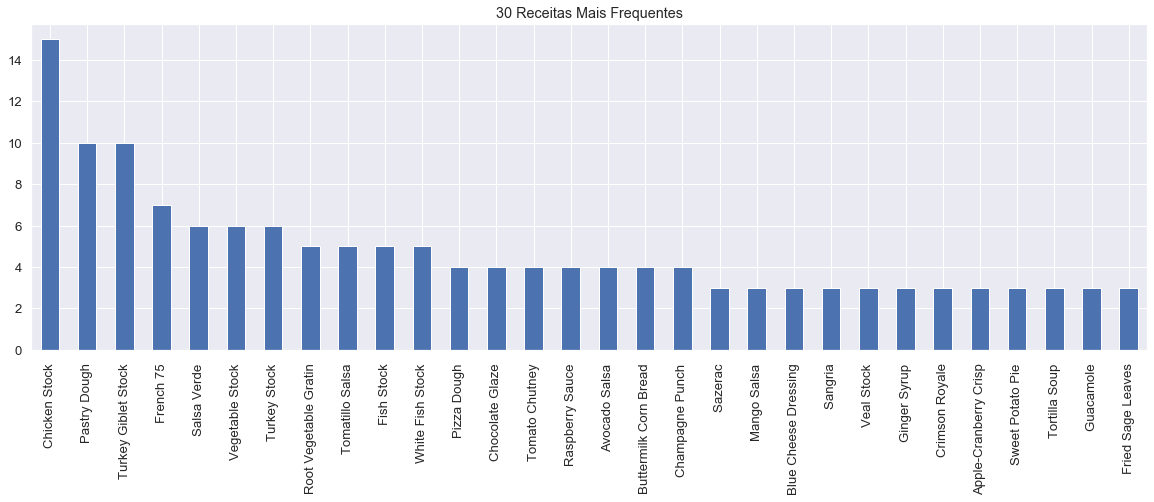

In [27]:
#Top 30 receitas que aparecem mais vezes
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
df['title'].value_counts().head(30).plot.bar().set_title('30 Receitas Mais Frequentes');

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
A seguir, os gráficos boxplot mostram as top 10 Receitas mais frequentes por "fat", "calories", "protein" e "sodium".
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

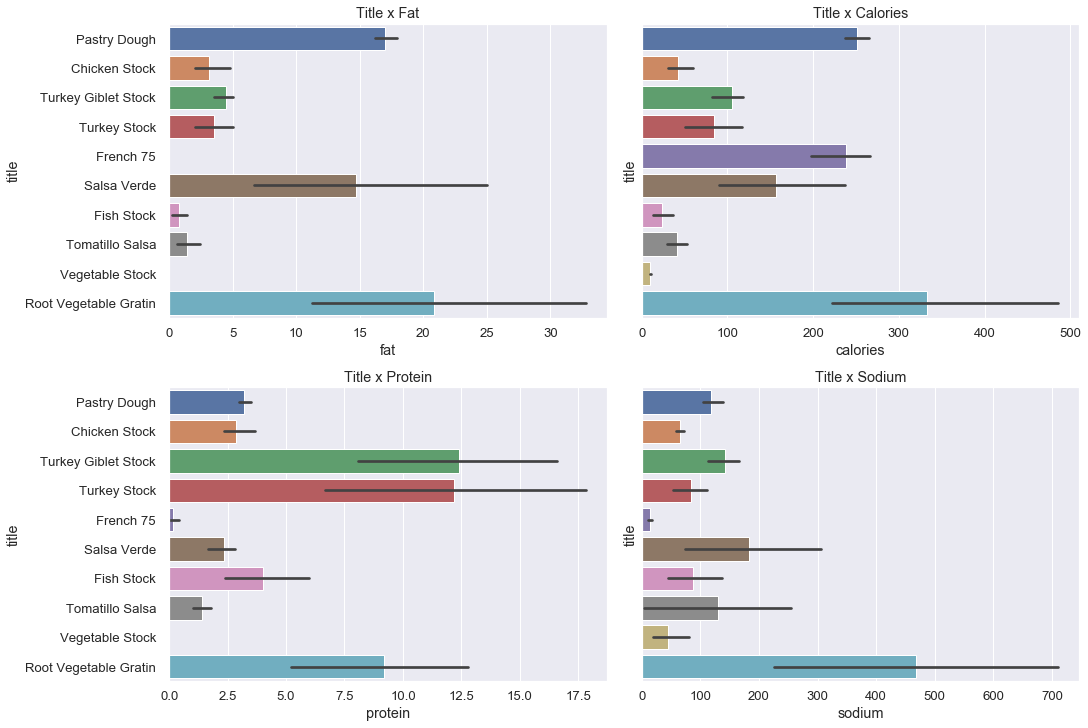

In [28]:
# Plot Top 10 receitas que aparecem mais vezes X nutrients
top_titles= list(df['title'].value_counts().head(10).keys())
df_title_rating=df[df['title'].isin(top_titles)]
fig1, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), constrained_layout=True, sharey=True)
sns.barplot(data=df_title_rating,y='title', x='fat', ax=axes[0,0]).set_title("Title x Fat")
sns.barplot(data=df_title_rating,y='title', x='calories', ax=axes[0,1]).set_title("Title x Calories")
sns.barplot(data=df_title_rating,y='title', x='protein', ax=axes[1,0]).set_title("Title x Protein")
sns.barplot(data=df_title_rating,y='title', x='sodium', ax=axes[1,1]).set_title("Title x Sodium");

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Abaixo é possível visualizar o gráfico de barra, que tem a Quantidade de Receitas cadastradas por Ano. Percebe-se que no ano de 2004 houve o maior número de receitas casdastradas.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

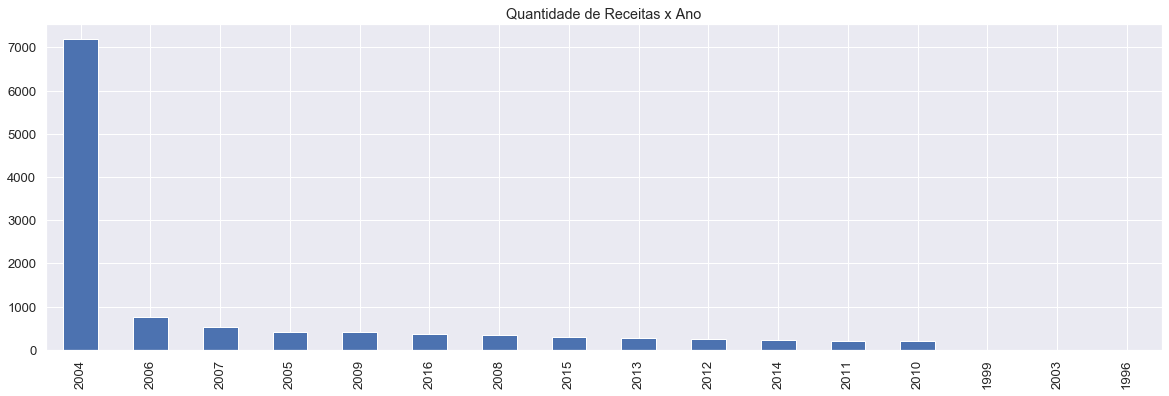

In [29]:
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
df['year'].value_counts().plot.bar().set_title('Quantidade de Receitas x Ano');

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Abaixo é possível visualizar o gráfico de barra, que tem a Quantidade de Receitas cadastradas por Mês. Percebe-se que o Mês  8(Agosto) tem o maior número de receitas cadastradas.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

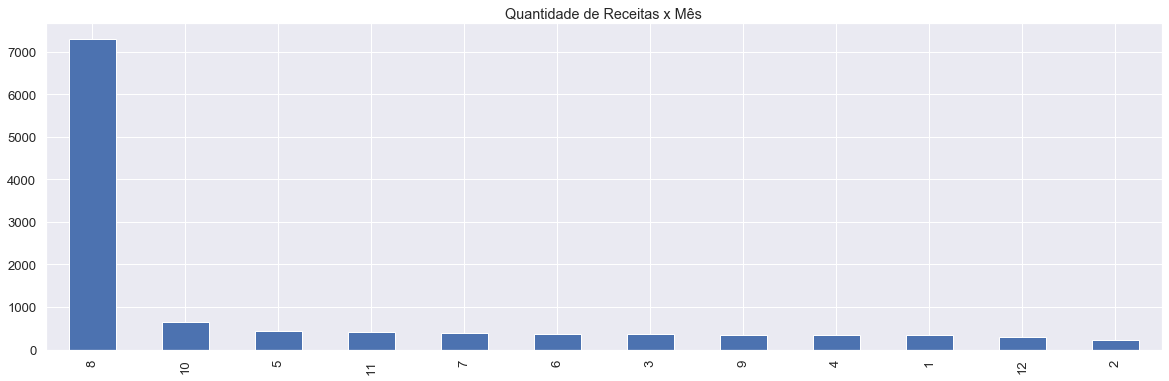

In [30]:
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
df['month'].value_counts().plot.bar().set_title('Quantidade de Receitas x Mês');

# 7. Tratamento da Feature Ingredients

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Para a feature "ingredients" ser utilizada de maneira mais eficaz, foi necessário realizar um tratamento para extrair apenas os ingredientes, deixando de lado outros elementos textuais que poderiam atrapalhar, como as medidas por exemplo. Para isso, foi implementada um função capaz de realizar esse tratamento.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
def treat_ingredients(ingredient):
    ingredient = str(ingredient).lower()
    stoplist = stopwords.words('english')
    ingredient = re.sub(r'\s\s+',' ',re.sub(r'[\d]|[(,),},{,.,^,?,~,=,+,\,,\-,_,\\,/,*,+,.,\,|,;]',' ',ingredient)).lstrip()
    stopwords_list = stoplist + ['small','teaspoon','fresh','chopped','chunk','dash','cut','tablespoon','cup','tablespoons','peeled','cups','teaspoons','large','grams','into','ounce']
    word_list = [ x.strip() for x in ingredient.split(" ")]
    aux = list(filter((lambda x: x not in stopwords_list), word_list))
    
    return " ".join(aux)

df_ingredients = df['ingredients'].explode().apply(lambda x: treat_ingredients(x))

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
Após o tratamento da feature "ingredients", foi feita uma análise dos 30 ingredientes mais utilizados. Abaixo é possível visualizar esta análise através de um gráfico de barras.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

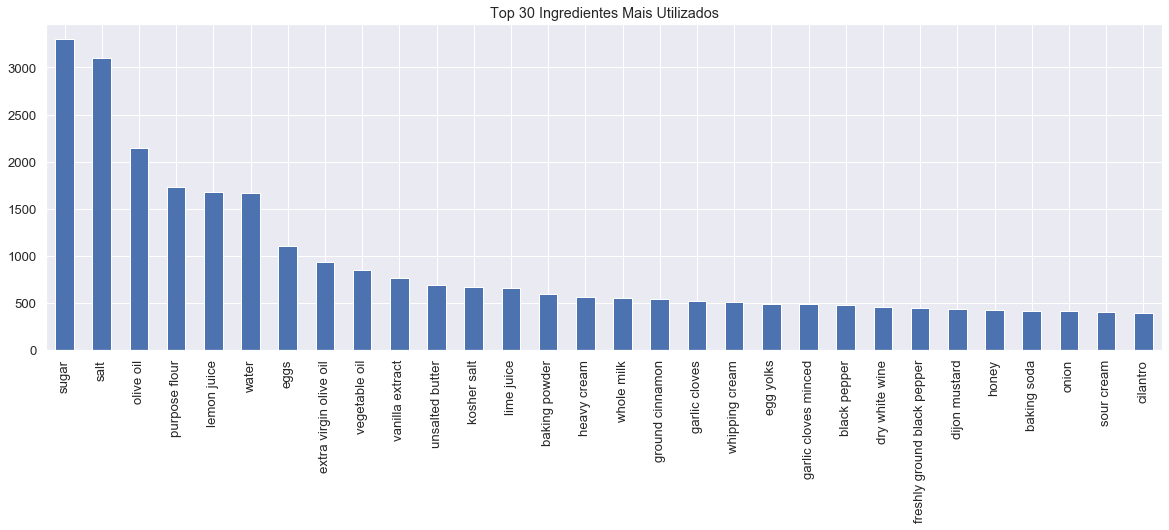

In [32]:
# Top 30 Ingredientes Mais Utilizados
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
df_ingredients.value_counts().head(30).plot.bar().set_title('Top 30 Ingredientes Mais Utilizados');

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
No grafico a seguir é possível visualizar a Quantidade de Ingredientes por Rating, onde é perceptível que as receitas com maiores classificações, entre 4 e 5, utilizam mais ingredientes.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

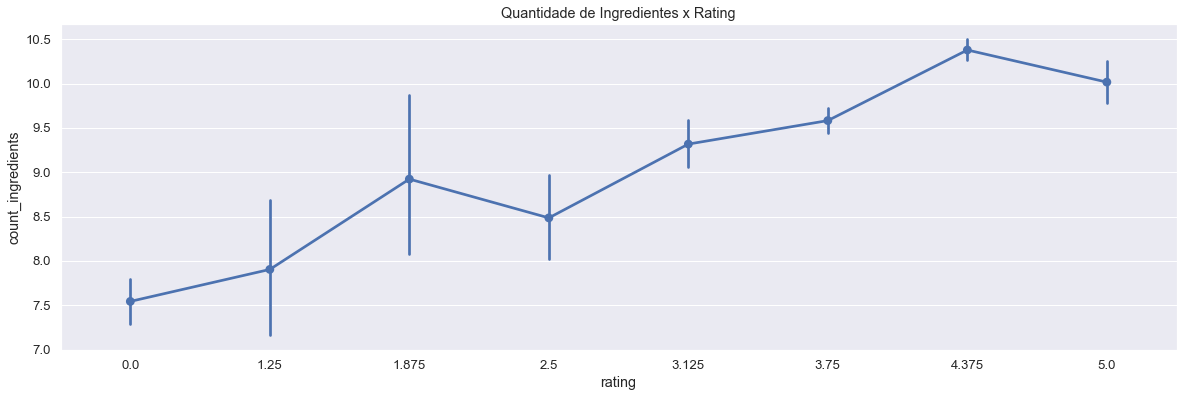

In [33]:
# Quantidade de Ingredients x Rating
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
sns.pointplot(data=df,x='rating', y='count_ingredients').set_title("Quantidade de Ingredientes x Rating");

### -------------------------------------------------------------------------------------------------------------------------------------------------------------------
No grafico a abaixo é possível visualizar a Quantidade de Ingredientes por Quantidade de Instruções. Percebe-se que as receitas com até 16 instruções tendem a utilizar mais ingredientes, após isso, há uma forte variação mas com tendencia de subida.
### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

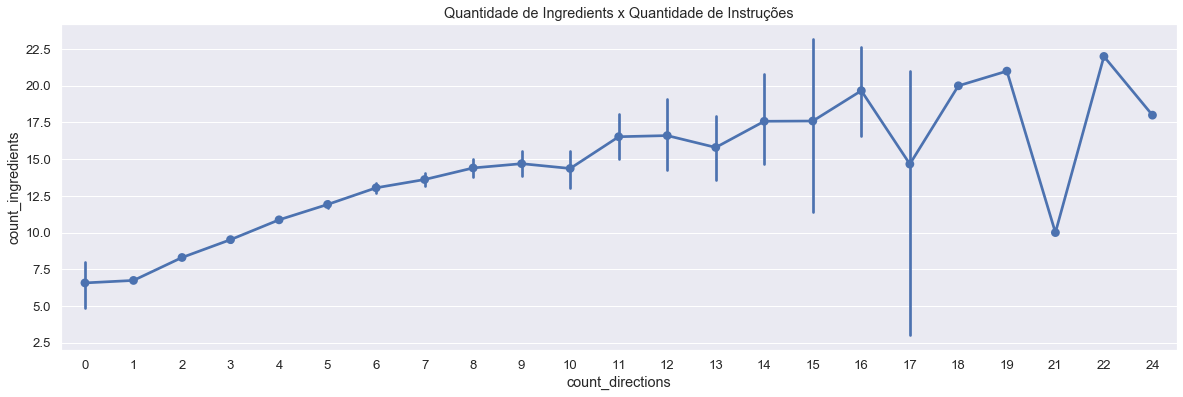

In [34]:
# Quantidade de Ingredientes x Rating
sns.set(font_scale=1.2)
plt.figure(figsize=(20,6))
sns.set_style('darkgrid')
sns.pointplot(data=df,x='count_directions', y='count_ingredients').set_title("Quantidade de Ingredients x Quantidade de Instruções");